# MODELLING

We develop models for predicting real time delivery of an order from different places. Three distinct machine learning models (Linera Regression, Random Forest Regression and Decision Tree Regression were utilized to estimate delivery time.

## ESTIMATE DELIVERY TIME

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import pickle

In [2]:
df = pd.read_csv('order_data_pr.csv')
df.head(1)

,order_id,customer_id,product_id,distance_km,product_rating,date,review,time_taken(min),place_id,product,product_description,product_type,place_type,place_name,place_address,place_phone_no,price
0,0,0,3711,46.99,3,6-4-22,0,43,88,Gala,"Gala, a popular on-the-go snack, has become sy...",snacks,cafes,Krispy Kreme,"389C Herbert Macaulay Way, Yaba, Lagos, Nigeria",NaN,700


In [4]:
# Split Data
X = df['distance_km'].values.reshape(-1,1)
y = df['time_taken(min)'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=0)

In [5]:
# Feature Engineering

# ===== Scaler =====
scaler = StandardScaler()

In [6]:
# Transforming train and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [7]:
X_train.shape,y_train.shape

((7219, 1), (7219,))

In [8]:
# Initialize model

RANDOM_STATE = 0
lr = LinearRegression()
rf = RandomForestRegressor(random_state=RANDOM_STATE)
dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

models = {'Linear_Regression':lr, 'RandomForest_Regressor':rf,
        'DecisionTree_Regressor':dt}

# Train models

models_list = []
for name,model in models.items():
    model.fit(X_train,y_train)
    models_list.append(name)

## Model Evaluation

Accuracy score and rmse were used to estimate the accuracy and validity of the models

In [9]:
# Evaluating model
accuracy_list, rmse_list = [], []
for name,model in models.items():
    y_pred = model.predict(X_test)
    test_score = model.score(X_test,y_test)
    accuracy_list.append(test_score)
    rmse = mse(y_test,y_pred, squared=False)
    rmse_list.append(rmse)
    print(f"{name} Test Set Accuracy:{test_score} rmse: {rmse}")

Linear_Regression Test Set Accuracy:0.779310527093613 rmse: 6.278553067213242
RandomForest_Regressor Test Set Accuracy:0.7045545695294466 rmse: 7.264527954047122
DecisionTree_Regressor Test Set Accuracy:0.6415897416047636 rmse: 8.00127093240131


In [10]:
# Making a Dataframe of each model and metrics

model_metrics_df = pd.DataFrame({'Model': models_list,'RMSE': rmse_list,'Accuracy_score': accuracy_list, } )
model_metrics_df

,Model,RMSE,Accuracy_score
0,Linear_Regression,6.278553,0.779311
1,RandomForest_Regressor,7.264528,0.704555
2,DecisionTree_Regressor,8.001271,0.641590


In [11]:
# Transpose metrics df
model_metrics_df = model_metrics_df.set_index('Model')
model_metrics_df = model_metrics_df.transpose()
model_metrics_df

Model,Linear_Regression,RandomForest_Regressor,DecisionTree_Regressor
RMSE,6.278553,7.264528,8.001271
Accuracy_score,0.779311,0.704555,0.641590


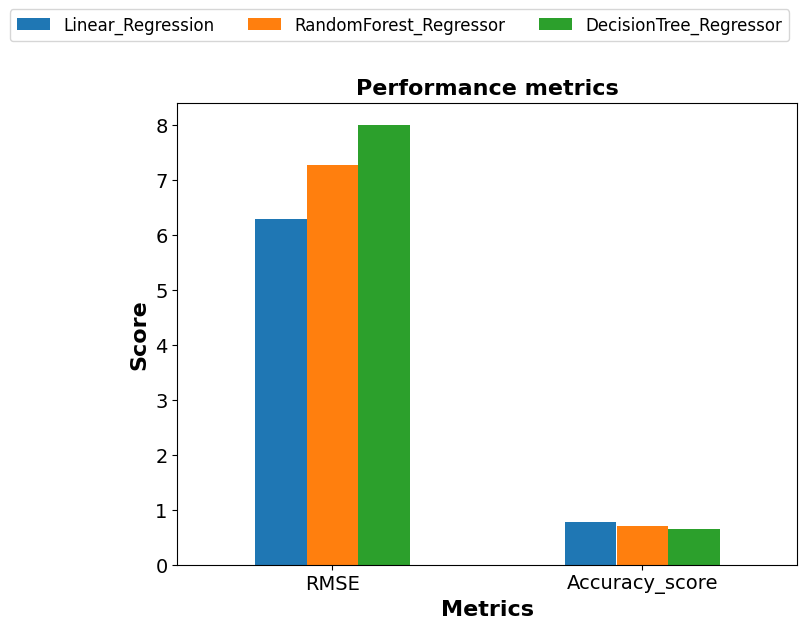

In [12]:
# Plot of metrics
ax = model_metrics_df.plot.bar(figsize=[8, 6])
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="best", ncol=3, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel("Metrics", fontsize=16, fontweight="bold")
ax.set_ylabel("Score", fontsize=16, fontweight="bold")
ax.set_title("Performance metrics", fontsize=16, fontweight="bold")
ax;

The model with the lowest rmse and best accuracy is Linear Regression

In [13]:
for name,model in models.items():
    y_pred = model.predict(X_test)
    print(f"{name} Predictions:{y_pred[:10]}")

Linear_Regression Predictions:[30.95899968 23.74742175 43.53105532 57.92528774 28.93435882 23.01469458
 30.19734907 27.56531595 38.47909431 16.612973  ]
RandomForest_Regressor Predictions:[28.90452381 18.06956566 40.10730952 65.31633333 25.77258333 20.8969881
 36.20833333 30.07169048 42.56679762 20.21733333]
DecisionTree_Regressor Predictions:[29.         17.8        39.         68.         26.5        21.
 40.         34.         42.66666667 19.        ]


In [14]:
# Saving model with pickle

pickle.dump(lr, open('model.pkl', 'wb'))

In [15]:
#Load the model from Pickle
pickled_model = pickle.load(open('model.pkl', 'rb'))
pickled_model.predict(X_test)

array([30.95899968, 23.74742175, 43.53105532, ..., 40.20485962,
       22.34945544, 21.36605845])

In [16]:
pickled_model.predict(np.array([40]).reshape(-1,1))

array([508.93369736])

## MEAL RECOMMENDATION

We used cosine similarity from product description and product type to recommend product to existing and new users. Used product rating to recommend best products and places to users

In [17]:
# Computing the vectorisation of product description text fitting and transforming it
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['product_description'] + df['product_type'])

In [18]:
# compute the cosine similarity for the computed matrix consisting of product and description
cos_sim = linear_kernel(tfidf_matrix)

In [19]:
# Get product data
sim_pred = df.reset_index()
product_name = df['product'].drop_duplicates()
indices = pd.Series(product_name.index, index=product_name.values)

In [20]:
# function that returns top 10 most similar products based on cosine similarity scores

def product_recommend(user_id):
    
    # old customer
    if user_id in df["customer_id"].to_list():
        #get customers previous order item
        customer_last_order = (df[df["customer_id"] == user_id]["product"]).to_list()[-1]

        # get the similarities based ond the user's last order 
        idx = indices[customer_last_order]
        sim = enumerate(cos_sim[idx])
        sim = sorted(sim, key=lambda x: x[1], reverse=True)

        sim_index = [i[0] for i in sim]
        sim_data = (df["product"].iloc[sim_index]).drop_duplicates()
    
        number = 0
        for i in sim_data[:10].tolist():
            number+=1
            rec_price = df[df['product'] == i][['place_name','product_rating','price']]
            rec_price = rec_price.sort_values('product_rating',ascending=False)[:5]
            place = rec_price['place_name'].tolist()
            price = [str (x) for x in rec_price['price'].tolist()]
            rest_dict = dict(zip(place, price))
            print(f"\n№ {number}")
            print(f"Product: {i}")
            for place, price in rest_dict.items():
                print(f"Place: {place}, Price: {price}")
    else:
        sim_data = (df["product"].drop_duplicates())
        number = 0
        for i in sim_data[:10].tolist():
            number+=1
            rec_price = df[["product","product_rating","place_name","price"]]
            rec_price = rec_price.sort_values('product_rating',ascending=False)[:5]
            place = rec_price['place_name'].tolist()
            price = [str (x) for x in rec_price['price'].tolist()]
            rest_dict = dict(zip(place, price))
            print(f"\n№ {number}")
            print(f"Product: {i}")
            for place, price in rest_dict.items():
                print(f"Place: {place}, Price: {price}")

In [21]:
# Existing user
product_recommend(user_id=56)


№ 1
Product: Beer
Place: Goat Hunters Restaurant, Price: 3200
Place: MyYa’s Cafe, Price: 2300
Place: Double Four Restaurant & Eatery, Price: 3200
Place: Krispy Kreme, Price: 2300
Place: Art Cafe, Price: 3400

№ 2
Product: Whisky
Place: SEE Lagos, Price: 4100
Place: Cafe One Yaba, Price: 4300
Place: Pause | Café & Espresso Bar, Price: 4900
Place: Stories Lagos, Price: 5100
Place: Ouida Cafe, Price: 5500

№ 3
Product:  Smoothie
Place: Darling - Ro Restaurant, Price: 2000
Place: Cafe One Yaba, Price: 1900
Place: Grey Matter Social Space, Price: 1100
Place: Pause | Café & Espresso Bar, Price: 1500
Place: Ziya Delicacy Boutique, Price: 2300

№ 4
Product: fura da nono
Place: Fresh Forte, Price: 800
Place: Enjoyurmouth.com, Price: 800
Place: Barcelos, Price: 600
Place: La Pointe Cafe, Price: 400
Place: Pause | Café & Espresso Bar, Price: 900

№ 5
Product: Wheat Meat Pie (Beef Pie)
Place: Cafe One Yaba, Price: 700
Place: New China Restaurant, Price: 500
Place: MY COFFEE, Price: 700
Place: Fre

In [22]:
# New user
product_recommend(user_id=-1)


№ 1
Product: Gala
Place: House J. Luxury Apartments & Restaurant, Price: 900
Place: Mia Delizia Italian Restaurante, Price: 1100
Place: Majesty's Kitchen, Price: 600
Place: Cafe One Yaba, Price: 3300
Place: Emperor's Hotels & Restaurant, Price: 1200

№ 2
Product: Chicken Pie
Place: House J. Luxury Apartments & Restaurant, Price: 900
Place: Mia Delizia Italian Restaurante, Price: 1100
Place: Majesty's Kitchen, Price: 600
Place: Cafe One Yaba, Price: 3300
Place: Emperor's Hotels & Restaurant, Price: 1200

№ 3
Product: Spicy Puff Puff
Place: House J. Luxury Apartments & Restaurant, Price: 900
Place: Mia Delizia Italian Restaurante, Price: 1100
Place: Majesty's Kitchen, Price: 600
Place: Cafe One Yaba, Price: 3300
Place: Emperor's Hotels & Restaurant, Price: 1200

№ 4
Product: Sandwich
Place: House J. Luxury Apartments & Restaurant, Price: 900
Place: Mia Delizia Italian Restaurante, Price: 1100
Place: Majesty's Kitchen, Price: 600
Place: Cafe One Yaba, Price: 3300
Place: Emperor's Hotels 

In [23]:
# saving the similarity
pickle.dump(cos_sim, open("similarity.pkl", "wb"))

In [24]:
# load the similarrity
cos =  pickle.load(open("similarity.pkl", "rb"))
cos

array([[1.        , 0.04461222, 0.02672211, ..., 0.02855413, 0.0228996 ,
        0.        ],
       [0.04461222, 1.        , 0.02376789, ..., 0.0238632 , 0.02765542,
        0.        ],
       [0.02672211, 0.02376789, 1.        , ..., 0.04063532, 0.01858867,
        0.02231874],
       ...,
       [0.02855413, 0.0238632 , 0.04063532, ..., 1.        , 0.03554608,
        0.018997  ],
       [0.0228996 , 0.02765542, 0.01858867, ..., 0.03554608, 1.        ,
        0.04227534],
       [0.        , 0.        , 0.02231874, ..., 0.018997  , 0.04227534,
        1.        ]])

In [25]:
# saving the data
pickle.dump(df, open("data.pkl", "wb"))